In [9]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import math
from datetime import datetime

from scipy import stats

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot  as plt

from google.oauth2 import service_account


In [10]:
isTrainData=False

isExploreMode=True

imported_to='2023-07-01'  # train to 30-06-23

In [11]:
threshold_x_sd = 3  # 2x-4x
split_test=0.2

In [12]:
projectId='smart-data-ml'

dw_dataset_id="SMartDW"
dw_table_id = f"{projectId}.{dw_dataset_id}.incident"

dataset_id='SMartML'

credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
client = bigquery.Client(credentials=credentials, project=projectId)
#client = bigquery.Client(project=projectId)

def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all
def loadDataFrameToBQ(table_id,dfx):
    try:
        job_config = bigquery.LoadJobConfig(
            write_disposition="WRITE_TRUNCATE",
        )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"{len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))

In [13]:
label='severity_id'
labelName='severity_name'

removeCols=['updated_at','imported_at']

# dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']
# numbericCols=['open_to_close_hour','response_to_resolved_hour']
# start_end_list=[ ['open_datetime','close_datetime'],['response_datetime','resolved_datetime']]

dateCols=['open_datetime','close_datetime']
numbericCols=['open_to_close_hour']
start_end_list=[ ['open_datetime','close_datetime']]


rangeCols=[]
cateCols=['sla','product_type','brand','service_type','incident_type']

# Explore and Transform Data

In [14]:
sql_all=f"""
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `{dw_table_id}` """

if isTrainData:
    print(f"Build train/test data by imported date < {datetime.strptime(imported_to,'%Y-%m-%d')}")

    train_name='train2_incident'
    test_name='test2_incident'
    train_table_id=f"{projectId}.{dataset_id}.{train_name}"
    test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
    print(f"TrainTable2={train_table_id} and TestTable2={test_tabel_id}")
    
    sql_all=f""" {sql_all}
    WHERE imported_at< '{imported_to}'
    order by imported_at desc
    
    """
    
else:
    print(f"Load new data by imported date >= {datetime.strptime(imported_to,'%Y-%m-%d')}")
    new_incident_name='new2_incident'    
    new_incident_table_id=f"{projectId}.{dataset_id}.{new_incident_name}"
    print(f"{new_incident_table_id}")
    
    sql_all=f""" {sql_all}
    WHERE imported_at>= '{imported_to}'
    order by imported_at desc
    
    """


print(sql_all)


Load new data by imported date >= 2023-07-01 00:00:00
smart-data-ml.SMartML.new2_incident
 
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `smart-data-ml.SMartDW.incident` 
    WHERE imported_at>= '2023-07-01'
    order by imported_at desc
    
    


In [15]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
df_all=df_all.drop_duplicates(subset=['id'],keep='last')

no_original_rows=len(df_all)

if len(df_all)==0:
 print("No records from bigquery")  
 quit()
else:
 print(f"Import at :{df_all['imported_at'].min()} - {df_all['imported_at'].max()}")
 print(f"Open Date : {df_all['open_datetime'].min()} - {df_all['open_datetime'].max()}")   
 print(df_all.shape)  
print(df_all.info())
print(df_all[["severity_id","severity_name","updated_at","imported_at"]].head())

Load data from Bigquery
Import at :2023-07-01 00:05:07.070048 - 2023-07-07 00:05:05.438671
Open Date : 2023-04-20 11:00:00 - 2023-07-06 07:47:00
(67, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 68
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              67 non-null     Int64         
 1   severity_id     67 non-null     Int64         
 2   severity_name   67 non-null     object        
 3   sla             67 non-null     object        
 4   product_type    67 non-null     object        
 5   brand           67 non-null     object        
 6   service_type    67 non-null     object        
 7   incident_type   67 non-null     object        
 8   open_datetime   67 non-null     datetime64[ns]
 9   close_datetime  67 non-null     datetime64[ns]
 10  updated_at      67 non-null     datetime64[ns]
 11  imported_at     67 non-null     datetime64[ns]
dtypes: Int64(2

# Manage Numberic Cols
### 1-Find Time Inverval
### 2-Remove outlier on Time Interval to service
### 3-Find any rows  contain zero time period
### 4-Create range from time-interval (best,good,moderate,bad,worst)

# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

we can convert hour to range   
* (0, 24] =by 1 day =best
* (24, 168] =  1day -1 week  =good
* (168, 360]=  1week- 15 days(half a month) =fair
* (360, 720]= 15 dasy-1 month =bad
* (720, 2349]=1 month-1 Q =worst

open_to_close_hour ,response_to_resolved_hour , Mostly  we can complate by 1 day (0, 24]
there are few cases that take long to close incident (360, 720]   15 day to  1month

In [16]:
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  

# df_all.tail()

# Remove oulier  and delete zero hour training data

In [17]:
if isTrainData :
    for col in  xScoreDiffHourCols:
      df_all=df_all.query(f"{col}<@threshold_x_sd")


    allRows=df_all.shape[0]
    for col in numbericCols:
        zeroRows=len(df_all.query(f"{col}==0"))
        pctZeroHour=round(zeroRows/allRows*100,1)
        print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
        df_all=df_all.query(f'{col}!=0')

# Apply Service Level

In [18]:
def service_hour_range(x_hour):
    if x_hour>0 and x_hour<=24:
      return "soonest"
    elif x_hour>25 and x_hour<=168:
      return "soon"
    elif x_hour>168 and x_hour<=360:
      return "fair"
    elif x_hour>360 and x_hour<=720:
      return "late"
    else:
      return "latest"

for col in numbericCols:
    range_col=f"range_{col}"
    rangeCols.append(range_col)
    df_all[range_col]=df_all[col].apply(service_hour_range)

# Final TRansform

In [19]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols
print(f"Remove {removeCols}")
df_all=df_all.drop(columns=removeCols)
no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

df_all[['id','severity_id']] =df_all[['id','severity_id']].astype('int64')

print(df_all.info())


print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable
# df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05]).drop(index=['count','std'])

df_all.tail(30)

Remove ['updated_at', 'imported_at', 'open_datetime', 'close_datetime', 'zscore_open_to_close_hour', 'open_to_close']
% remove data 0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 68
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        67 non-null     int64  
 1   severity_id               67 non-null     int64  
 2   severity_name             67 non-null     object 
 3   sla                       67 non-null     object 
 4   product_type              67 non-null     object 
 5   brand                     67 non-null     object 
 6   service_type              67 non-null     object 
 7   incident_type             67 non-null     object 
 8   open_to_close_hour        67 non-null     float64
 9   range_open_to_close_hour  67 non-null     object 
dtypes: float64(1), int64(2), object(7)
memory usage: 5.8+ KB
None
pct removed data =0.0


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,range_open_to_close_hour
39,3050,2,Major,24x7 4Hrs Resolution Time,Software,Veeam,Incident,Software,1.000000,soonest
40,3046,2,Major,24x7 4Hrs Resolution Time,Software,Veeam,Incident,Software,2.066667,soonest
41,3045,3,Minor,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Other Failure,30.833333,soon
42,3042,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,6.500000,soonest
43,3039,2,Major,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,General Incident,0.800000,soonest
44,2990,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,1782.000000,latest
45,3000,2,Major,24x7 4Hrs Resolution Time,Software,Red Hat,Incident,Software,189.700000,fair
46,3012,2,Major,24x7 4Hrs Resolution Time,Software,Veeam,Incident,Software,81.033333,soon
47,3052,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Software,76.000000,soon
48,3053,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Software,4.000000,soonest


In [20]:
# # https://www.geeksforgeeks.org/pandas-cut-method-in-python/
# def explore_ranges_numberic_val(col,rangeList):
#     print(col)
#     rangeList.sort()
#     return pd.cut(df_all[col],rangeList, right=True).value_counts()
# range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
# print(explore_ranges_numberic_val('open_to_close_hour',range1))
# print("=======================================================")

# range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
# print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
# print("=======================================================")



# Plot Numeric  and Category columns

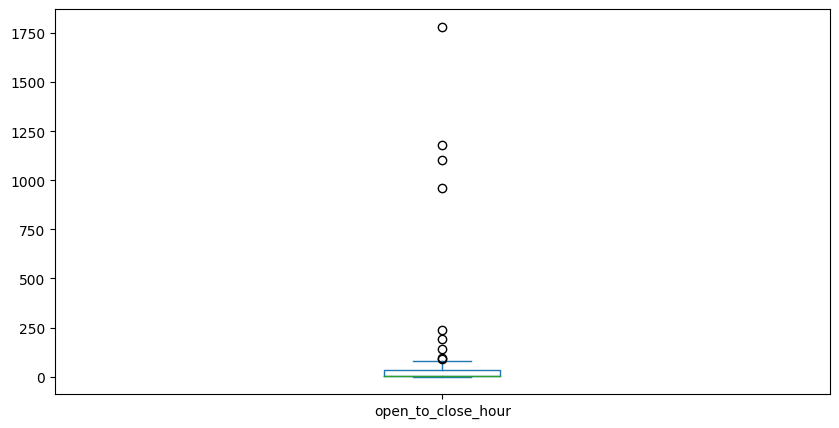

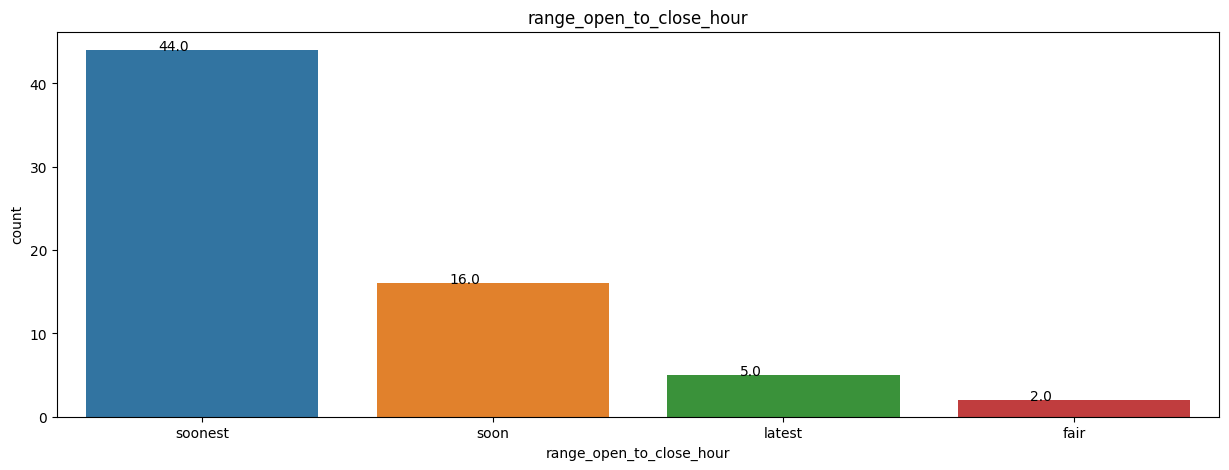

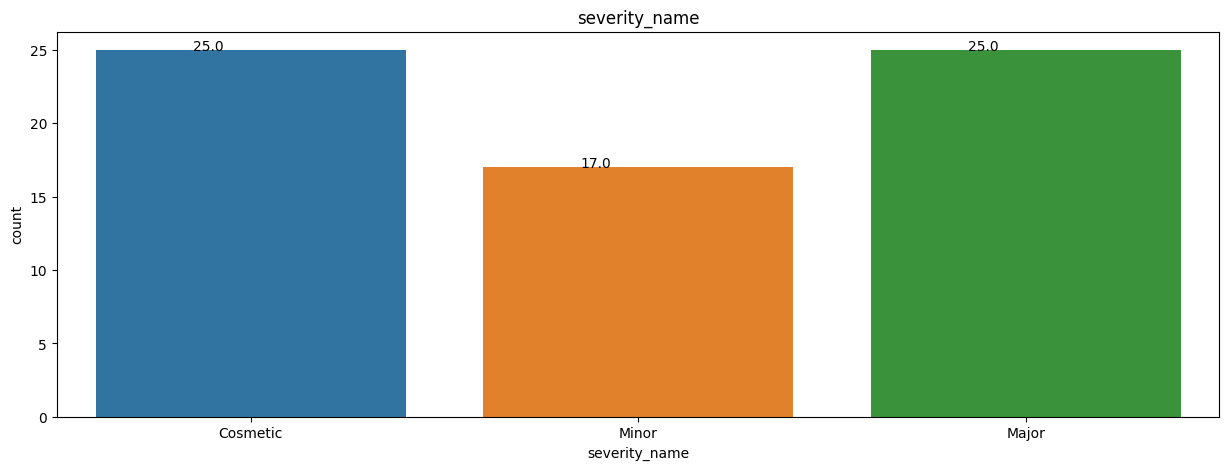

In [21]:
if isExploreMode:
    df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
    plt.show()
    
if isExploreMode:
    barCols=rangeCols+["severity_name"]
    for col in barCols:
        fig , ax = plt.subplots(figsize=(15,5))
        ax =sns.countplot(x=col, data=df_all,)
        for p in ax.patches:
           ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
        plt.title(col)
        plt.show()

# Build Label and Split into Train/Test DataSet

In [22]:
if isTrainData:
    # create label
    map_severity_to_class={4:0,3: 1, 2: 2, 1: 3}
    print(f"Map severity id to LabelCode: {str(map_severity_to_class)}")

    df_all['label_multi_severity'] =df_all['severity_id'].map(map_severity_to_class) 
    def map_4to2_serverity(severity_id):
        if severity_id==1 or severity_id==2:
           return 1
        else:
           return 0 
    df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

    print( list(df_all['label_multi_severity'].unique()))
    print(df_all['label_binary_severity'].unique())

    #Split data into 2 dataset to BQ
    len_all=len(df_all)
    print(f"All Data = {len_all}")

    # Split the 80% of total as train
    # The remaining  will be splited equally 50% for valuation and the rest of later part is test

    train, test = train_test_split(df_all,test_size=split_test,random_state=1000,shuffle=True)

    len_all=len(df_all)
    len_train=len(train)

    len_test=len(test)
    print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
    print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

    print(train.tail())

    loadDataFrameToBQ(train_table_id,train)
    loadDataFrameToBQ(test_tabel_id,test)  
    
    # if isExploreMode:
    #     train.to_csv(f"data/{train_name}.csv",index=False)
    #     test.to_csv(f"data/{test_name}.csv",index=False)
        
else:
    loadDataFrameToBQ(new_incident_table_id,df_all)
    

67 rows imported to smart-data-ml.SMartML.new2_incident successfully
